# Gaussian Model

## 1.a Swaption pricing by Monte Carlo

The swaption price at time 0, $V_0$, is given by the following expression $$
    \begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} r(s) \ \mathrm{d}s}Swap(T_0)^+\Big] \\
&= P(0,T_0) \ \mathbb{E}_{\mathbb{Q}}\Big[e^{-\int_{0}^{T_0} x(s) \ \mathrm{d}s}\Big(1-P(T_0,T_N,x(T_0),y(T_0))-K\sum_{n=0}^{N-1} \tau_n P(T_0,T_{n+1},x(T_0),y(T_0)\Big)^+\Big]
\end{array}
$$
And $$\forall n \in [|0,N|], \quad P(T_0,T_n,x,y) = \frac{P(0,T_n)}{P(0,T_0)} e^{-G(T_0,T_N)x-\frac{1}{2}G(T_0,T_N)^2 y}$$

One will use a Monte Carlo estimator of the expectation above by using M independent simulations $S_m$ so that
$$\hat{V_0} = \frac{1}{M} \sum_{m=1}^M S_m$$
$$\forall m, \ S_m = e^{I_m} \ \Big(P(0,T_0)-P(0,T_0)P(T_0,T_n,x_m,y_m) - KP(0,T_0) A(T_0,x_m,y_m)\Big)^+$$
Where we have noted $x_m,y_m,I_m$ the m-th Euler simulation of $x(T_0),y(T_0), I(T_0)$ and 
$$A(t,x,y) = \sum_{n=0}^{N-1} \tau_n \frac{P(0,T_{n+1})}{P(0,t)} e^{-G(t,T_{n+1})x - \frac{1}{2}G(t,T_{n+1})^2 y}$$

## 1.b Euler discretization

We aim to discretize the following differential system with an Euler scheme

$$\left\{
    \begin{array}{ll}
       \mathrm{d}x(t) &= (y(t) - \chi(t) x(t)) \ \mathrm{d}t \ + \ \sigma_r(t) \ \mathrm{d}Wt\\
       \mathrm{d}y(t) &= (\sigma_r(t)^2-2\chi(t)y(t)) \ \mathrm{d}t
    \end{array}
\right.$$

**Constant mean reversion and linear local volatility:** First, let for simplicity $$\chi(t) = \chi \in \mathbb{R}$$ and $$\sigma_r(t) = \sigma_r(t,x(t),y(t)) = \lambda(a + bx(t))$$

One defines a discretized time interval $0=t_0 < t_1 < ... < t_N = T_0$ and $\forall i \in [|0,N-1|], \ \Delta_i = t_{i+1} -t_i$

We will simulate $x(T_O)$ and $y(T_O)$ thanks to the scheme:
$$\left\{
    \begin{array}{ll}
       x_{t_{i+1}} &= x_{t_i} + (y_{t_i} - \chi x_{t_i}) \ \Delta_i \ + \ \lambda(a+bx_{t_i}) \ \sqrt{\Delta_i} Z_i \qquad  ,Z_i \sim \mathcal{N}(0,1) \\
       y_{t_{i+1}} &= y_{t_i} + (\lambda^2(a+bx_{t_i})^2-2\chi y_{t_i}) \ \Delta_i
    \end{array}
\right.$$

What's more, one has to simulate the variable $$I(T_0)=-\int_{0}^{T_0} x(s) \ \mathrm{d}s$$
As $\mathrm{d}I(t) = -x(t) \ \mathrm{d}t$, in line with the results above, one defines
$$I_{t_{i+1}} = I_{t_i} - x_{t_i} \ \Delta_i$$

**Remark:** The explicit Euler scheme is described above, but it is possible to implement implicit Euler scheme instead


In order to price swaptions, one needs the values of the zero coupon bonds for each maturity $\Big(P(0,T_i)\Big)_{i=0,N}$. One can calculate it with $$P(0,T_i) = e^{-\int_{0}^{T_i}f(0,u) \ \mathrm{d}u}$$, but one needs again **the initial forward curve** $t \rightarrow f(0,t)$


To do some calculations and to have a first simple approach, I have chosen to fixe $P(0,T) = e^{-rT}$ even if it's completely wrong in our model because the short rate is stochastic.

## 2.Useful functions

In [1]:
#modules

import numpy as np
import math
from random import *
from time import time
import scipy.stats as stats
import scipy.integrate as integrate
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(10)

un_sur_sqrt_pi = 1/(np.sqrt(2*np.pi))

def gaussian_density(x):
    return un_sur_sqrt_pi*np.exp(-0.5*x**2)

In [2]:
#Plotting functions

def plot2D(x,y,xlabel,ylabel,title,z=[],zlabel=''):
    plt.figure()
    plt.xlabel(xlabel)
    plt.title(title)
    plt.plot(x,y,label=ylabel)
    if z != []:
        plt.plot(x,z,label=zlabel)
    plt.legend()
    plt.show()
    
def plot3D(X, Y, Z,angle):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('K')
    ax.set_ylabel('T0')
    ax.set_zlabel('vol')
    ax.set_title('Implied vol')
    ax.view_init(40,angle)

In [3]:
#import ZC data P(0.5*j) j=0,100
import csv
ZC = []
with open('./ZC.csv') as my_file:
    my_file_reader = csv.reader(my_file, delimiter=',', quotechar='"')
    for x in my_file_reader:
        ZC.append([float(y) for y in x])
ZC = ZC[0]

In [112]:
#One set the parameters
chi = 1
lmbda = 1
a = 1
b = 1
K = 0.05
N = 20
M = 100000
r = 0.05

# tenor for tests
maturities = np.arange(0.5,5.5,0.5)     #tenor structure of the underlying swap T0=6M,1Y,...5Y=TN
T0 = maturities[0]
#bonds from data
bonds_data = ZC[int(T0*2):int(maturities[-1]*2)+1]  #P(0,T_i) for T_i in maturities
#bonds approximation
bonds = [np.exp(-r*t) for t in maturities]

## 3.Simulation

In [80]:
#Simulation of the diffusions x,y,I
#

def simul(lmbda,a,b,chi,T0,N,M):
    delta = np.linspace(0,T0,N+1)
    resu = []
    for m in range(M):
        (x,y,I) =(0,0,0)
        Z = np.random.standard_normal(N)
        for i in range(N):
            delta_i = delta[i+1]-delta[i]
            sigma_i = lmbda*(a+b*x)
            I = I - x*delta_i                          
            x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z[i]
            y = y + (sigma_i**2 -2*chi*y)*delta_i
        resu.append((x,y,I))
    return resu

In [85]:
#test
s = simul(lmbda,a,b,chi,T0,N,1)
print(s)

[(-0.1781417731609296, 0.34645612468067866, -0.009179266470184386)]


In [10]:
#function G 
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

#payoff of the swaption at T0
def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

In [14]:
#test

payoff_swaption(maturities,bonds,x,y,chi,K)

0.6244023245787115

In [97]:
#pricing of the swaption by Monte Carlo algorithm
#N is the parameter of discretization in the Euler scheme
#M is the number of simulations in the Monte Carlo estimation
#K is the strike of teh swaption


def swaption_MC(M,sim,K,chi,bonds,maturities,exec_time=False,variance = False):
    t1 = time()
    T0 = maturities[0]
    Monte_Carlo = 0
    moment_2 = 0
    for m in range(M):
        (x,y,I) = (sim[m][0],sim[m][1],sim[m][2])
        s_m = np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        Monte_Carlo += s_m
        moment_2 += s_m**2
    t2 = time()
    price = Monte_Carlo/M
    if(exec_time):
        print("Execution time: ",t2-t1, "sec")
    if(variance):
        var = moment_2/M - price**2
        print("Variance:",var)
    return price


In [99]:
#tests 
sim = simul(lmbda,a,b,chi,T0,N,M)

swaption_MC(M,sim,K,chi,bonds,maturities,True,True)

Execution time:  4.569495916366577 sec
Variance: 0.04869513980740463


0.18684957814030895

In [119]:
#Annuity in the model
#args: -maturities: array of the tenor dates 
#- bonds: array of the ZC curve at tenor dates P(0,T0)...P(0,TN)
#-ZC_t : value of P(0,t)

def A(t,x,y,maturities,bonds,ZC_t,chi,order=0):
    nb_maturities = len(maturities)
    if (t==0):
        return sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    else:
        resu = 0
        for n in range(maturities.size-1):
            g = G(t,maturities[n+1],chi)
            resu += (maturities[n+1]-maturities[n])*(bonds[n+1]/ZC_t)*np.exp(-1*g*x-0.5*y*g**2)*g**order
    return resu

# Swap rate in the model
def S(t,x,y,maturities,bonds,ZC_t,chi):
    if (t==0):
        return (bonds[0]-bonds[-1])/A(t,x,y,maturities,bonds,ZC_t,chi)
    else:
        g0 = G(t,maturities[0],chi)
        gN = G(t,maturities[-1],chi)
        PT0 = bonds[0]*np.exp(-1*g0*x-0.5*y*g0**2)
        PTN = bonds[-1]*np.exp(-1*gN*x-0.5*y*gN**2)
        return (PT0-PTN)/A(t,x,y,maturities,bonds,ZC_t,chi)

# dS/dx
def q(t,x,y,maturities,bonds,ZC_t,chi):
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    B = A(t,x,y,maturities,bonds,ZC_t,chi,1) # A prime
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    qt = (PTN*gN - PT0*g0)/At + (PT0-PTN)*B/(At**2)
    return qt

## Effect of volatility's parameters

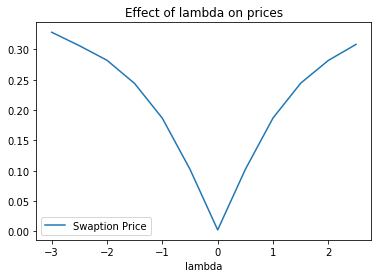

In [93]:
lmbdas = np.arange(-3,3,0.5)
swaptions = []
for l in lmbdas:
    sim = simul(l,a,b,chi,T0,N,M)
    swaptions.append(swaption_MC(M,sim,K,chi,bonds,maturities))

plot2D(lmbdas,swaptions,'lambda','Swaption Price','Effect of lambda on prices')

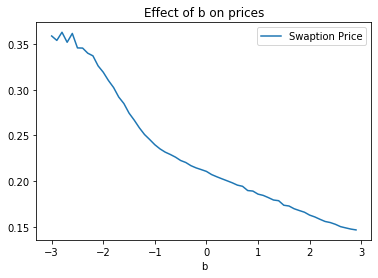

In [96]:
b_val = np.arange(-3,3,0.1)
swaptions = []
for bi in b_val:
    sim = simul(lmbda,a,bi,chi,T0,N,M)
    swaptions.append(swaption_MC(M,sim,K,chi,bonds,maturities))

plot2D(b_val,swaptions,'b','Swaption Price','Effect of b on prices')

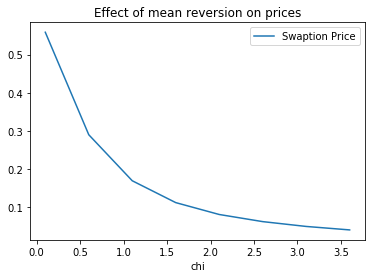

In [95]:
mean_reversion_val = np.arange(0.1,4,0.5)
swaptions = []
for mr in mean_reversion_val:
    sim = simul(lmbda,a,b,mr,T0,N,M)
    swaptions.append(swaption_MC(M,sim,K,mr,bonds,maturities))

plot2D(mean_reversion_val,swaptions,'chi','Swaption Price','Effect of mean reversion on prices')

**Remark:** One observes that the swaption volatility decreases as the mean reversion increases as it is said p. 553 in Piterbarg. Indeed, the mean reversion parameter tends to keep the factor x around a mean level

## Implied volatility

### Log normal swap rate
Assume that the swap rate $S$ is log-normal. We have the following diffusion $$\mathrm{d}S_{T0,...,T_N}(t) = S_{T0,...,T_N}(t)\sigma \ \mathrm{d}W_t$$ because it has to be a martingale under $\mathbb{Q}^A$ where $$\frac{\mathrm{d}\mathbb{Q}^A}{\mathrm{d}\mathbb{Q}}\Big| _{\mathcal{F}_t} = \frac{A(t)}{A(0)} e^{-\int_{0}^{t} r(s) \ \mathrm{d}s}$$

Hence $$\begin{array}{ll} V_0 &= \mathbb{E}_{\mathbb{Q}}\Big[ e^{-\int_{0}^{t} r(s) \ \mathrm{d}s} Swap(T_0)^+ \Big]
= A(0) \mathbb{E}_{\mathbb{Q}^A}\Big[ \big(S(T_0) -K \big) \mathbb{1}_{S(T_0)>K} \Big] \end{array}$$

Let $$\frac{\mathrm{d}\tilde{\mathbb{Q}}}{\mathrm{d}\mathbb{Q}^A} = \frac{S(T_0)}{\mathbb{E}[S(T_0)]} = e^{-\frac{\sigma^2}{2}T_0 + \sigma W_{T_0}}$$ and by Girsanov's Theorem, $$\tilde{W}_t = W^A_t - \sigma t$$ is a Brownian motion under $\tilde{\mathbb{Q}}$.

It leads to a Black Scholes formula by:
$$\begin{array}{ll} V_0 &= A(0)S(0) \tilde{\mathbb{Q}} \Big(S(0) e^{\frac{\sigma^2}{2}T_0 + \sigma \tilde{W}_{T_0}} > K \Big) \ -K A(0) \mathbb{Q}^A \Big( \sigma W_{T_0} > \ln{\frac{K}{S(0)}} + \frac{\sigma^2}{2} T_0 \Big) \\
&= \boxed{A(0)S(0) \Phi(d^+) \ -KA(0) \Phi(d^-)}
\end{array}$$

$$\left\{
    \begin{array}{ll}
       d^+ &= \frac{\ln{\frac{S(0)}{K}} + \frac{\sigma^2}{2} T_0}{\sigma \sqrt{T_0}} \\
       d^- &= d^+ - \sigma \sqrt{T_0}
    \end{array}
\right.$$

In particular, $\frac{\partial d^+}{\partial \sigma} = \frac{\partial d^-}{\partial \sigma} + \sqrt{T_0}$ and 
$$vega = \frac{\partial V_0}{\partial \sigma} = A(0)S(0) \frac{\partial d^+}{\partial \sigma} \phi(d^+) \ -K A(0) \frac{\partial d^-}{\partial \sigma} \phi(d^-) \\
= A(0)S(0) \sqrt{\frac{T_0}{2\pi}} e^{-\frac{(d^+)^2}{2}}$$ ($\Phi$ is the cdf of the standard normal law and $\phi$ its density function.)

First view of Black scholes prices to be sure that the pricing formula is right and that the asymptotic behavior is the expected one, i.e $V_0 \rightarrow_{\sigma \to \infty} A(0)S(0)$ and $V_0 \rightarrow_{\sigma \to 0^+} A(0) (S(0)-K)^+$

lim_infty= 0.19650912895692774 lim_0 = 0.0024461293681064646


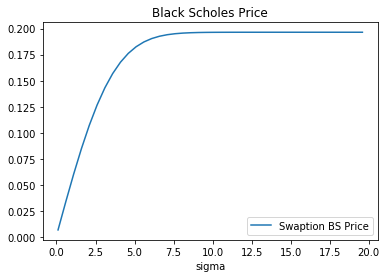

In [100]:
#Black Scholes Price

def Price_BS(S0,A0,T0,K,sigma):
    d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
    return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))

T0 = maturities[0]
nb_maturities = maturities.size
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
sigma_val = np.arange(0.1,20,0.5)
BS_prices = [Price_BS(S0,A0,T0,K,s) for s in sigma_val]
lim_0 = A0*max(0,S0-K)
print('lim_infty=',S0*A0,'lim_0 =',lim_0)


plot2D(sigma_val,BS_prices,'sigma','Swaption BS Price','Black Scholes Price')

### Newton-Raphson algorithm

The simple Newton-Raphson algorithm, applied to find the zero of the function $\sigma \rightarrow V_0(\sigma) - \hat{V}$ where $\hat{V}$ is the observed marked to market value of the swaption, is written:

$$\left\{
    \begin{array}{ll}
       \sigma_0 \quad \text{chosen}\\
       \sigma_{n+1} = \sigma_n - \bigg( \frac{V_0(\sigma_n) - \hat{V}}{\frac{\partial V_0}{\partial \sigma}(\sigma_n)} \bigg)
    \end{array}
\right.$$

In [101]:
def Newton_Raphson(sigma0, nb_it, Mtm, bonds, K, maturities):
    sigma = sigma0
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    
    for i in range(nb_it):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        price_BS = (bonds[0]-bonds[-1])* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
        derivative = (bonds[0]-bonds[-1])*np.sqrt(T0/(2*np.pi))*np.exp(-0.5*d**2)
        sigma = sigma - (price_BS-Mtm)/derivative
    return sigma

Newton_Raphson(1,1,0.01,bonds,0.5,maturities)

12.50264292852606

There is some instability with the Newton-Raphson algorithm because the derivative of the Black Scholes price tends to be very small.

### Dichotomie

In [102]:
def bissectrice(nb_it, Mtm, bonds, K, maturities):
    T0 = maturities[0]   
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)

    x = 0
    y = 1
    for i in range(nb_it):
        z = (x+y)/2
        sigma = z/(1-z)
        price_BS = Price_BS(S0,A0,T0,K,sigma)

        if(Mtm > price_BS):
            x = z
        else:
            y = z
    z = (x+y)/2
    return z/(1-z)

bissectrice(10,0.01,bonds,0.05,maturities)

0.1590265987549519

### Root finding by Python's algorithm

In [178]:
# méthode bissectrice de Python

def biss_python(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    if(Mtm >= S0*A0):
        print("!! Le prix d'entrée est au-dessus des limites BS!!",Mtm, ">", S0*A0)
    if(Mtm <= A0*max(0,S0-K)):
        print("!! Le prix d'entrée est en-dessous des limites BS!!", Mtm, "<", A0*max(0,S0-K))
    return opt.bisect(lambda x: Price_BS(S0,A0,T0,K,x) - Mtm, 0.001, 50)
    #return opt.bisect(lambda x: swaption_normal(x,K,maturities,bonds) - Mtm, 0.001, 50)


In [104]:
#Brent's method

def Brent(Mtm, bonds, K, maturities):
    T0 = maturities[0] 
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    f = lambda x: Price_BS(S0,A0,T0,K,x) - Mtm
    return opt.brentq(f, 0.001, 20)


This algorithm is efficient but stops wether $f(a)f(b)>0$ at one moment

In [105]:
#Essai sur un prix BS avec sigma connu et comparaison des méthodes

sigma = 0.5
nb_maturities = maturities.size
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi) 
Market_price = Price_BS(S0,A0,T0,1,sigma)

New_vol = Newton_Raphson(0.1, 1, Market_price, bonds, 1, maturities)
bissec_vol = bissectrice(10, Market_price, bonds, 1, maturities)
python_vol = biss_python(Market_price,bonds,1,maturities)
Brent_vol = Brent(Market_price,bonds,1,maturities)
print("Vol BS:", sigma,"Implied vol Newton:",New_vol,"Implied vol Bissec:",bissec_vol,"Implied vol python", python_vol,"Implied vol Brent: ",Brent_vol
)

Vol BS: 0.5 Implied vol Newton: inf Implied vol Bissec: 0.5003663003663004 Implied vol python 0.4999999999990462 Implied vol Brent:  0.49999999999971473


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


### Effect of K

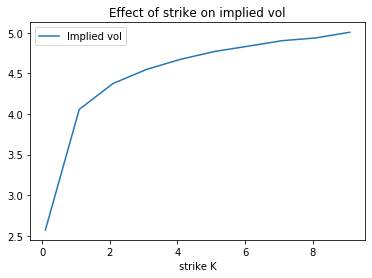

In [106]:
strikes = np.arange(0.1,10,1)
impli_vol = [bissectrice(10,0.1,bonds,k,maturities) for k in strikes]

plot2D(strikes,impli_vol,'strike K','Implied vol','Effect of strike on implied vol')

**Explanation:** One should have an implied volatility surface which is decreasing with respect to strike K, but this phenomenon is justified by the fact that input price is the same for all values of K and is 'randomly' chosen. Indeed Black & Scholes price is decreasing with respect to K: $$\frac{\partial V_0}{\partial K} = A(0)S(0) \frac{\partial d^+}{\partial K} \phi(d^+) \ -A(0)K \frac{\partial d^-}{\partial K} \phi(d^-) - A(0) \Phi(d^-)$$

And $\frac{\partial d^+}{\partial K} = \frac{\partial d^-}{\partial K} = \frac{-1}{\sigma \sqrt{T_0}K}$

So $$\frac{\partial V_0}{\partial K} = \frac{-A(0)}{\sigma\sqrt{T_0}} \Big( \frac{S(0)}{K}\phi(d^+)-\phi(d^+-\sigma\sqrt{T_0}) \Big) \ -A(0) \Phi(d^-) = -A(0) \Phi(d^-) \ \le 0$$

Hence if $K_1 \le K_2, \quad \hat{V} = V_0(K_1,\sigma_1) = V_0(K_2,\sigma_2)$ then $\sigma_2 \ge \sigma_1$ which explains the behavior of the curve above.

One should rather calculate the Monte Carlo Swaption Price for each strike instead of plotting the implied volatility calculated on a single Price

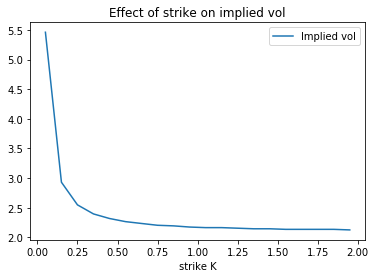

In [117]:
#MC(K) = BS(K,sigma)

sim = simul(lmbda,a,b,chi,T0,N,M)
strikes = np.arange(0.05,2,0.1)
implied_vol = []
for k in strikes:
    Price = swaption_MC(M,sim,k,chi,bonds,maturities)
    implied_vol.append(bissectrice(10,Price,bonds,k,maturities))

plot2D(strikes,implied_vol,'strike K','Implied vol','Effect of strike on implied vol')

**Remark:** Here one observes an implied volatility curve which is decreasing with respect to the strike K as expected. However no smile phenomenon is remarkable here and higher values of the strike implies more unstability in the inversion algorithm and the observations would have no sense.

### Effect of T0

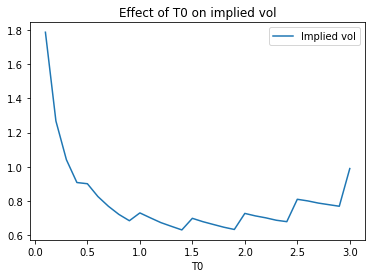

In [192]:
T0s = np.arange(0.1,3.1,0.1)
impli_vol = [bissectrice(10,0.05,[np.exp(-r*m) for m in np.arange(t,5.5,0.5)],K,np.arange(t,5.5,0.5)) for t in T0s]

plot2D(T0s,impli_vol,'T0','Implied vol','Effect of T0 on implied vol')

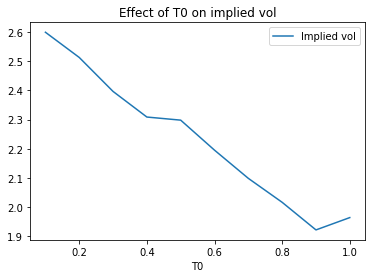

In [197]:
# MC(T0) = BS(T0,sigma)
T0s = np.arange(0.1,1.1,0.1)
implied_vol = []
for T in T0s:
    sim = simul(lmbda,a,b,chi,T,N,M)
    tenor = np.arange(T,5.5,0.5)
    bonds = [np.exp(-r*m) for m in tenor]
    Price = swaption_MC(M,sim,0.5,chi,bonds,tenor)
    implied_vol.append(bissectrice(10,Price,bonds,0.5,tenor))
    
plot2D(T0s,implied_vol,'T0','Implied vol','Effect of T0 on implied vol')

**Remark:** The volatility surface observed in the market is in general decreasing with respect to the maturity, as we can observe here

### Reliability of bissection method
One will input a swaption price calculated by the Black & Scholes formula for a known volatility. The generated surface is then supposed to be flat and equal to this level of volatility. It is a way to check if the inversion method is unstable somewhere. $$V_0^{BS}(T0,K,\sigma) = \hat{V}$$

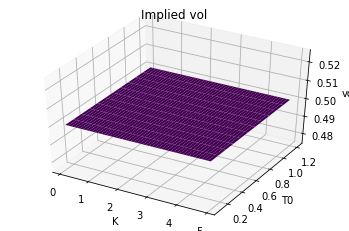

In [157]:
#from a BS price with sigma known --> flat curve in theory
T0s = np.arange(0.1,1.3,0.1)
strikes = np.arange(0.1,5,0.1)
X,Y = np.meshgrid(strikes, T0s)
sigma = 0.5
Z = np.zeros((T0s.size,strikes.size))
i,j= 0,0
for t in T0s:
    maturities = np.arange(t,5)
    bonds = [np.exp(-r*m) for m in maturities]
    nb_maturities = maturities.size
    A0 = sum([(maturities[i+1]-maturities[i])*bonds[i+1] for i in range(0,nb_maturities-1)])
    S0 = (bonds[0]-bonds[-1])/A0
    for k in strikes: 
        Price = Price_BS(S0,A0,t,k,sigma)
        vol = bissectrice(10,Price, bonds, k, maturities)
        Z[i][j] = vol
        #Z[i][j] = Brent(Price_BS(S0,A0,t,k,sigma), bonds, k, maturities)
        #print("K=",k,"T0=",t,"Price=",Price,"vol=",vol,"Zi,j=",Z[i][j])
        j = (j+1)%strikes.size
    i+=1
        
plot3D(X,Y,Z,300)

**Remark:** It can be osbserved that the implied volatility surface is flat almost everywhere. However implied volatility seems to vanish for low levels of $K$ and $T_0$. The lower the input volatility is, the more important is the unstability.

Now one will inverse a price given by the Monte Carlo method described before. $$V_0^{BS}(T0,K,\sigma) = V_0^{MC}(T_0,K)$$

## Implied Volatility surface building

### Normal model

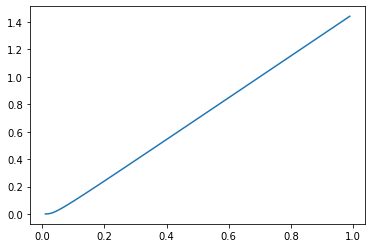

In [159]:
# Implied vol. surface for normal model dSt = sigma*dWt

def swaption_normal(sigma,K,maturities,bonds):
    T = maturities[0]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    d = (S0-K)/(sigma*np.sqrt(T))
    return A0*((S0-K)*stats.norm.cdf(d) + sigma*np.sqrt(T)*gaussian_density(d))

vol = np.arange(0.01,1,0.01)
maturities = np.arange(1,5.5,0.5)
bonds = ZC[2:11]
normal_prices = [swaption_normal(v,0.05,maturities,bonds) for v in vol]
plt.plot(vol,normal_prices)

In [164]:

strikes = np.arange(0.01,0.3,0.01)
T0s = np.arange(0.5,3,0.5)
X,Y = np.meshgrid(strikes, T0s)
surface = np.zeros((T0s.size,strikes.size))
i,j= 0,0
for t in T0s:
    sim = simul(lmbda,a,b,chi,t,N,M)
    maturities = np.arange(t,5.5,0.5)
    bonds = ZC[int(t*2):11]
    for k in strikes:
        Price = swaption_MC(M,sim,k,chi,bonds,maturities)
        #surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
        surface[i][j] = biss_python(Price,bonds,k,maturities)
        j = (j+1)%strikes.size
    i+=1
    

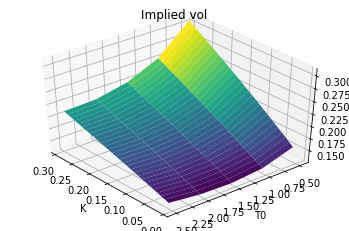

In [165]:
plot3D(X,Y,surface,140)

### Quasi gaussian model

In [171]:
#construction of an implied volatility surface

def construct_surface(strikes,T0s,M,N,lmbda,a,b,chi):
    surface = np.zeros((T0s.size,strikes.size))
    i,j= 0,0
    for t in T0s:
        maturities = np.arange(t,5.5,0.5)
        #bonds = ZC[int(t*2):11]
        bonds = [np.exp(-r*m) for m in maturities]
        sim = simul(lmbda,a,b,chi,t,N,M)
        for k in strikes:
            print(t,k)
            Price = swaption_MC(M,sim,k,chi,bonds,maturities)
            #surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
            surface[i][j] = biss_python(Price,bonds,k,maturities)
            j = (j+1)%strikes.size
        i+=1
    return surface

In [174]:
#print the values of (T0,K) for which the MC price of the swaption is above the BS limit
strikes = np.arange(0.01,0.25,0.01)
T0s = np.arange(0.5,3,0.5)
prices = np.zeros((T0s.size,strikes.size))
i,j=0,0
for t in T0s:
    maturities = np.arange(t,5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    sim = simul(lmbda,a,b,chi,t,N,M)
    
    for k in strikes:
        Price = swaption_MC(M,sim,k,chi,bonds,maturities)
        prices[i][j] = Price
        if (A0*S0 - Price <=0):
            print(t,k,"!! / ! \ !! Prix au dessus des limites BS", A0*S0-Price)
        if (A0*max(S0-k,0) - Price >=0):
            print(t,k,"!! / ! \ !! Prix en dessous des limites BS", A0*max(S0-k,0)-Price) 
        j = (j+1)%strikes.size
    i+=1

0.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.05056338695940504
0.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.0327143848186294
0.5 0.03 !! / ! \ !! Prix au dessus des limites BS -0.01654797281153944
0.5 0.04 !! / ! \ !! Prix au dessus des limites BS -0.001871808719862672
1.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.07634424277581972
1.0 0.02 !! / ! \ !! Prix au dessus des limites BS -0.06200969299304723
1.0 0.03 !! / ! \ !! Prix au dessus des limites BS -0.04882687493437049
1.0 0.04 !! / ! \ !! Prix au dessus des limites BS -0.03672474849041013
1.0 0.05 !! / ! \ !! Prix au dessus des limites BS -0.025641186957542778
1.0 0.060000000000000005 !! / ! \ !! Prix au dessus des limites BS -0.015440894978189679
1.0 0.06999999999999999 !! / ! \ !! Prix au dessus des limites BS -0.006051549215340485
1.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.09110913928753958
1.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.07912373086966751
1.5 0.03 !! / ! \ !! Prix au d

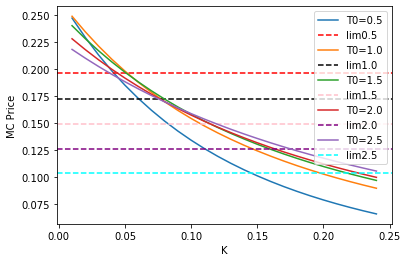

In [176]:
colors=['r','black','pink','purple','cyan']
for i in range(len(T0s)):
    t = T0s[i]
    maturities = np.arange(t,5.5,0.5)
    bonds = [np.exp(-r*m) for m in maturities]
    #bonds = ZC[int(2*t):11]
    limit = S(0,0,0,maturities,bonds,1,chi)*A(0,0,0,maturities,bonds,1,chi)
    plt.plot(strikes,prices[i],label="T0="+str(t))
    plt.axhline(y=limit, color=colors[i] ,linestyle='--',label="lim" + str(t))
plt.xlabel("K")
plt.ylabel("MC Price")
plt.legend()
plt.show()

0.1 0.1
0.1 0.2
0.1 0.30000000000000004
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7000000000000001
0.1 0.8
0.1 0.9
0.1 1.0
0.1 1.1
0.1 1.2000000000000002
0.1 1.3000000000000003
0.1 1.4000000000000001
0.1 1.5000000000000002
0.1 1.6
0.1 1.7000000000000002
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
0.1 1.8000000000000003
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
0.1 1.9000000000000001
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
0.2 0.1
0.2 0.2
0.2 0.30000000000000004
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7000000000000001
0.2 0.8
0.2 0.9
0.2 1.0
0.2 1.1
0.2 1.2000000000000002
0.2 1.3000000000000003
0.2 1.4000000000000001
0.2 1.5000000000000002
0.2 1.6
0.2 1.7000000000000002
0.2 1.8000000000000003
0.2 1.9000000000000001
0.30000000000000004 0.1
0.30000000000000004 0.2
0.30000000000000004 0.30000000000000004
0.30000000000000004 0.4
0.30000000000000004 0.5
0.30000000000000004 0.6
0.30000000000000004 0.7000000000000001
0.30000000000000004 0.8
0.3000000000000

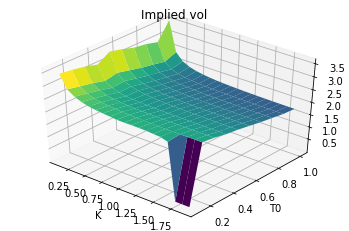

In [172]:
# plot of the implied volatility surface with Monte Carlo Prices as input prices

strikes = np.arange(0.1,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface(strikes,T0s,M,N,lmbda,a,b,chi)
        
plot3D(X,Y,Z,-50)  

In [185]:
# Compute the IV where it fails with different Euler simulation
u = [1.7,1.8,1.9]
maturities = np.arange(0.1,5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
for i in range(5):
    print("Step" + str(i))
    sim = simul(lmbda,a,b,chi,0.1,N,M)
    for stk in u:
        Price = swaption_MC(M,sim,stk,chi,bonds,maturities)
        iv = biss_python(Price,bonds,stk,maturities)
        if (A0*max(S0-k,0) - Price >=0):
            print("Limité dépassée")
        else:
            print("OK")

Step0
OK
OK
OK
Step1
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
!! Le prix d'entrée est en-dessous des limites BS!! 0.0 < 0.0
Limité dépassée
Step2
OK
OK
OK
Step3
OK
OK
OK
Step4
OK
OK
OK


**Conclusion:** One can see that depending on the Euler simulation, the Implied Vol. can be computed or not. One deduces that the problem comes from the Euler scheme.

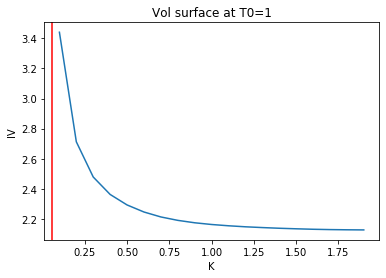

In [190]:
strikes = np.arange(0.1,2,0.1)
plt.plot(strikes,Z[4])
plt.xlabel("K")
plt.ylabel("IV")
plt.title("Vol surface at T0=1")
ATM = S(0,0,0,np.arange(0.5,5.5,0.5),[np.exp(-r*m) for m in maturities],1,chi)
plt.axvline(ATM, 0, 1, label='pyplot vertical line',color='r')
plt.show()

### ATM prices

In [191]:
T0s = np.arange(0.5,3.5,0.5)
for i in range(T0s.size):
    T = T0s[i]
    tenor = np.arange(T,5.5,0.5) #tenor of the swaption between T0 and 5Y
    bonds = [np.exp(-r*m) for m in tenor]
    print("ATM Price for T0=",T,"Y: ", S(0,0,0,tenor,bonds,1,chi))

ATM Price for T0= 0.5 Y:  0.05063024104885767
ATM Price for T0= 1.0 Y:  0.05063024104885769
ATM Price for T0= 1.5 Y:  0.05063024104885767
ATM Price for T0= 2.0 Y:  0.050630241048857653
ATM Price for T0= 2.5 Y:  0.0506302410488577
ATM Price for T0= 3.0 Y:  0.050630241048857674


**Idea:** One can observe some anomalies in the region around $(T_0,K) = (0.2 Y, 0.5)$ which could be generated by the random simulation made during the pricing step. Indeed with this version of the algorithm, one has generated $M$ samples of $(x,y,I)$ for each point of the grid. Even with a high value of $M$, differences could happen, that's why one would prefer to generate only one time $M$ samples of $(x,y,I)$ and do the Monte Carlo pricing with these samples for each point of the grid.

## An other surface building

In [98]:
#One simulate a unique time M samples (x,y,I)

def simul2(x0,y0,I0,lmbda,a,b,chi,delta):
    N = delta.size
    (x,y,I) =(x0,y0,I0)
    for i in range(N-1):
        delta_i = delta[i+1]-delta[i]
        sigma_i = lmbda*(a+b*x)
        Z = float(np.random.standard_normal(1))
        I = I - x*delta_i
        x = x +(y-chi*x)*delta_i + sigma_i*math.sqrt(delta_i)*Z
        y = y + (sigma_i**2 -2*chi*y)*delta_i
    return [x,y,I]

def MC(M,sim,K,chi,bonds,maturities,exec_time=False):
    Monte_Carlo = 0
    for m in range(M):
        (x,y,I) = (sim[m][0],sim[m][1],sim[m][2])
        Monte_Carlo += np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        
    return Monte_Carlo/M

def construct_surface2(strikes,T0s,M,N,lmbda,a,b,chi):
    surface = np.zeros((T0s.size,strikes.size))
    sim = [(0,0,0)] * M
    i,j= 0,0
    for t in T0s:
        if i==0:
            delta = np.linspace(0,t,N+1)
        else:
            delta = np.linspace(T0s[i-1],T0s[i],N+1)
            
        sim = [simul2(sim[m][0],sim[m][1],sim[m][2],lmbda,a,b,chi,delta) for m in range(M)]
        maturities = np.arange(t,5)
        bonds = [np.exp(-r*m) for m in maturities]
        for k in strikes:
            Price = MC(M,sim,k,chi,bonds,maturities)
            surface[i][j] = bissectrice(10,Price, bonds, k, maturities)
            j = (j+1)%(strikes.size)
        i+=1
    return surface

In [68]:
t1=time()
strikes = np.arange(0.1,2,0.1)
T0s = np.arange(0.1,1.1,0.1)
X,Y = np.meshgrid(strikes, T0s)
Z = construct_surface2(strikes,T0s,M,N,lmbda,a,b,chi)
t2=time()
print("Exec time:",t2-t1)

Exec time: 492.00112795829773


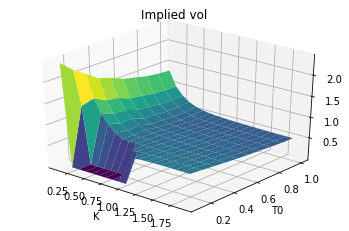

In [69]:
plot3D(X,Y,Z,-50)

### Skew

In [99]:
T0s = np.arange(0.5,3.5,0.5)
#Build the curve (T0,skew ATM)
def skew_curve(T0s,lmbda,a,b,chi):
    skew = np.zeros(T0s.size)
    for i in range(T0s.size):
        T0 = T0s[i]
        tenor = np.arange(T0,5.5,0.5) #tenor of the swaption between T0 and 5Y
        bonds = [np.exp(-r*m) for m in tenor]
        sim = simul(lmbda,a,b,chi,T0,N,M)
        ATM = S(0,0,0,tenor,bonds,1,chi)   # ATM rate = S0
        Price_95 = swaption_MC(M,sim,0.95*ATM,chi,bonds,tenor) #Swaption Price at 95% of the ATM strike
        Price_105 = swaption_MC(M,sim,1.05*ATM,chi,bonds,tenor) #Swaption Price at 105% of the ATM strike
        skew[i] = (bissectrice(10,Price_105, bonds, 1.05*ATM, tenor) - bissectrice(10,Price_95, bonds, 0.95*ATM, tenor))/(0.1*ATM)
    return skew

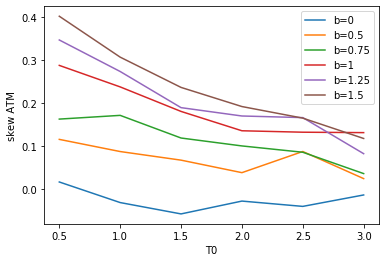

In [44]:
#skew ATM with respect to T0
plt.figure()
for b in [0,0.5,0.75,1,1.25,1.5]:
    plt.plot(T0s,skew_curve(T0s,lmbda,a,b,chi),label="b="+str(b))
plt.legend()
plt.xlabel("T0")
plt.ylabel("skew ATM")
plt.show()

In [81]:
# skew at fixed T0 with respect to K

T0 = 0.5
strikes = np.arange(0.4,2.6,0.2)
tenor = np.arange(T0,5.5,0.5)
bonds = [np.exp(-r*m) for m in tenor]
sim = simul(lmbda,a,b,chi,T0,N,M)
skew = []
for k in strikes:
    Price_95 = swaption_MC(M,sim,0.95*ATM,chi,bonds,tenor)
    Price_105 = swaption_MC(M,sim,1.05*ATM,chi,bonds,tenor)
    slope = (bissectrice(10,Price_105, bonds, 1.05*k, tenor) - bissectrice(10,Price_95, bonds, 0.95*k, tenor))/(0.1*k)
    skew.append(slope)

In [83]:
T0 = 1
strikes = np.arange(0.4,2.6,0.2)
tenor = np.arange(T0,5.5,0.5)
bonds = [np.exp(-r*m) for m in tenor]
sim = simul(lmbda,a,b,chi,T0,N,M)
skew2 = []
for k in strikes:
    Price_95 = swaption_MC(M,sim,0.95*ATM,chi,bonds,tenor)
    Price_105 = swaption_MC(M,sim,1.05*ATM,chi,bonds,tenor)
    slope = (bissectrice(10,Price_105, bonds, 1.05*k, tenor) - bissectrice(10,Price_95, bonds, 0.95*k, tenor))/(0.1*k)
    skew2.append(slope)

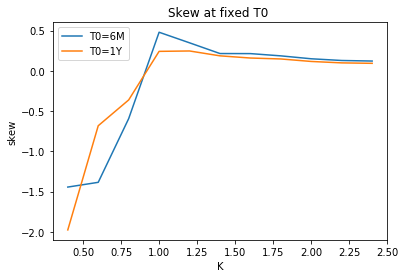

In [88]:
plt.figure()
plt.plot(strikes,skew,label="T0=6M")
plt.plot(strikes,skew2,label="T0=1Y")
plt.title("Skew at fixed T0 ")
plt.legend()
plt.xlabel("K")
plt.ylabel("skew")
plt.show()

One deduces from this curve that for a fixed swaption maturity $T_0$, the slope of the implied volatility is negative until $K \approx 1$ then there is a positive slope which seems to tend to zero when $K$ takes high values. This confirms the convex shape of the implied volatility with respect to strikes.

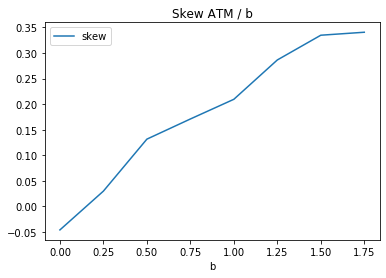

In [89]:
# T0 fixed, skew ATM with respect to b
b_vals = np.arange(0,2,0.25)
skew = [skew_curve(np.array([T0]),lmbda,a,b,chi) for b in b_vals]
plot2D(b_vals,skew,"b","skew","Skew ATM / b")

The curvature of the implied volatility seems to be increasing in $b$.

### Displaced log normal swap rate

Assume that the swap rate follows the following dynamic under $\mathbb{Q}^A$ $$\begin{array}{ll} \mathrm{d}S(t) &= \sigma \big( bS(t) + (1-b)S(0) \big) \ \mathrm{d}W^A(t) \\ &= \sigma \big( bS(t) + \beta \big) \ \mathrm{d}W^A(t) \end{array}$$

If $U(t) = b S(t) + \beta$, one has $$\mathrm{d}U(t) = b \mathrm{d}S(t) = b \sigma U(t) \ \mathrm{d}W^A(t)$$ 
Hence $$\boxed{U(T) = U(t) e^{b \sigma ( W^A_T - W^A_t) - \frac{b^2 \sigma^2}{2}(T-t)}}$$

In this framework, $$V_{swaption}(t) = A(t) \mathbb{E}\Big[\Big( S(T_0)-K \Big)^+ \Big | \mathcal{F}_t]$$

By variable change and Black Scholes formula, it yields $$\boxed{V_{swaption}(t) = A(t) \Big( \big(S(t)+\frac{1-b}{b}S(0) \big) \Phi(d^+) - \big(K+ \frac{1-b}{b}S(0)\big) \Phi(d^-) \Big) \\
d^{+/-} = \frac{\ln{\big( \frac{bS(t) + (1-b)S(0)}{bK+(1-b)S(0)}\big)} +_{/-} \frac{\sigma^2 b^2}{2}(T_0-t)}{\sigma b \sqrt{T_0-t}}}$$

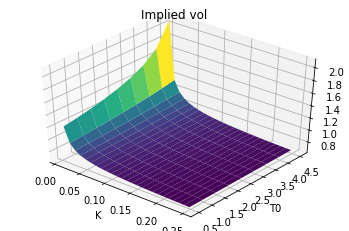

In [231]:
sigma = 1
b = 0.5
def log_displaced(sigma,b,K,maturities,bonds):
    T = maturities[0]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    if b==0:
        d = (S0-K)/(sigma*S0*np.sqrt(T))
        return A0 * (S0-K) * stats.norm.cdf(d) + A0 * sigma * S0 * np.sqrt(T) * gaussian_density(d)
    
    d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*sigma**2 * b**2 * T)/(sigma*b*np.sqrt(T))
    return A0*S0/b * stats.norm.cdf(d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(d - sigma*b*np.sqrt(T))

strikes = np.arange(0.008,0.25,0.01)
T0s = np.arange(0.5,5,0.5)
IV = np.zeros((T0s.size,strikes.size))
i,j= 0,0
for t in T0s:
    maturities = np.arange(t,10.5,0.5)
    bonds = ZC[int(t*2):21]
    for k in strikes:
        Price = log_displaced(sigma,b,k,maturities,bonds)
        #print(t,k,A0_obs(maturities,bonds)*S0_obs(maturities,bonds)-Price)
        #IV[i][j] = bissectrice(10,Price, bonds, k, maturities)
        IV[i][j] = biss_python(Price, bonds, k, maturities)
        j = (j+1)%strikes.size
    i+=1
    
X,Y = np.meshgrid(strikes, T0s)
plot3D(X,Y,IV,-50)

lim_0= 0.013016443657306316 lim_infty= 0.10258464706859627


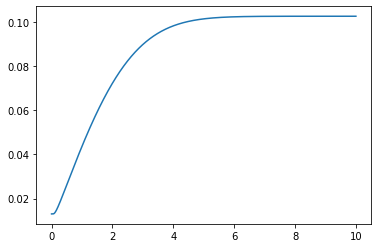

In [243]:
#Plot of the log displaced price for sigma
k = 0.01
vol = np.arange(0.001,10,0.001)
maturities = np.arange(1,5.5,0.5)
bonds = ZC[2:11]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
print("lim_0=",A0*max(S0-k,0),"lim_infty=",A0*S0/b)
log_displaced_price = [log_displaced(v/b,b,k,maturities,bonds) for v in vol]
plt.plot(vol,log_displaced_price)

In [223]:
#print the values of (T0,K) for which the log displaced price of the swaption is above the BS limit
strikes = np.arange(0.01,0.3,0.01)
T0s = np.arange(0.5,10,0.5)

for t in T0s:
    maturities = np.arange(t,10.5,0.5)
    bonds = ZC[int(t*2):21]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    
    for k in strikes:
        Price = log_displaced(sigma,b,k,maturities,bonds)
        if (A0*S0 - Price <=0):
            print(t,k,"!! / ! \ !! Prix au dessus des limites BS", A0*S0-Price)
        if (A0*max(S0-k,0) - Price >=0):
            print(t,k,"!! / ! \ !! Prix en dessous des limites BS", A0*max(S0-k,0)-Price) 

5.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.0004710606813214946
6.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.002381497611884789
6.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.0037249042348057593
7.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.004560111926264716
7.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.0048354210578954865
8.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.004647459382687121
8.0 0.02 !! / ! \ !! Prix au dessus des limites BS -0.00016592524470356376
8.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.004144833613404227
8.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.0008719609120141324
9.0 0.01 !! / ! \ !! Prix au dessus des limites BS -0.0032561347658581832
9.0 0.02 !! / ! \ !! Prix au dessus des limites BS -0.001122539566451506
9.5 0.01 !! / ! \ !! Prix au dessus des limites BS -0.0018166227424389041
9.5 0.02 !! / ! \ !! Prix au dessus des limites BS -0.0007809649762051882


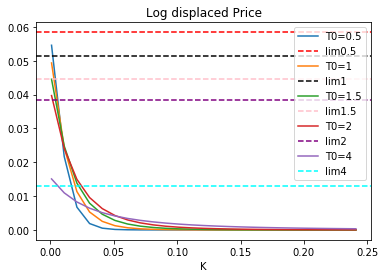

In [221]:
#Plot du prix log displaced en fonction de T0 et K et limite BS

strikes = np.arange(0.001,0.25,0.01)
T0s = [0.5,1,1.5,2,4]
colors=['r','black','pink','purple','cyan']
i=0
for t in T0s:
    maturities = np.arange(t,5.5,0.5)
    bonds = ZC[int(2*t):11]
    limit = A(0,0,0,maturities,bonds,1,chi)*S(0,0,0,maturities,bonds,1,chi)
    log_disp_prices_K = [log_displaced(sigma,b,k,maturities,bonds) for k in strikes]
    plt.plot(strikes,log_disp_prices_K,label="T0="+str(t))
    plt.axhline(y=limit, color=colors[i] ,linestyle='--',label="lim" + str(t))
    i +=1
    
plt.xlabel("K")
plt.title("Log displaced Price")
plt.legend()

**One observes that the price in this model overcomes the Black & Scholes limit as K tends to 0 and $T_0$ tends to $T_N$.**

Mathematically speaking, $$\lim_{T_0 \rightarrow + \infty} \lim_{K \rightarrow 0^+} d^{+ /_-} = + /_- \infty$$

Hence $$\lim_{T_0 \rightarrow + \infty} \lim_{K \rightarrow 0^+} V_{Swaption LD} = \frac{A(0) S(0)}{b} \ge A(0) S(0) = \lim_{\sigma \rightarrow + \infty} V_{BS}$$ 

It is then possible that the Price from the log-displaced model overcomes the superior bound of the Black Scholes Price for low values of strike and values of maturity near to $T_N$.

In [127]:
def skew_ld(T0s,b,sigma):
    skew = np.zeros(T0s.size)
    for i in range(T0s.size):
        T0 = T0s[i]
        tenor = np.arange(T0,5.5,0.5)  #tenor of the swaption between T0 and 5Y
        bonds = ZC[int(T0*2):11]
        ATM = S0_obs(tenor,bonds)   # ATM rate = S0
        Price_95 = log_displaced(sigma,b,0.95*ATM,tenor) #Swaption Price at 95% of the ATM strike
        Price_105 = log_displaced(sigma,b,1.05*ATM,tenor) #Swaption Price at 105% of the ATM strike
        #skew[i] = (bissectrice(10,Price_105, bonds, 1.05*ATM, tenor) - bissectrice(10,Price_95, bonds, 0.95*ATM, tenor))/(0.1*ATM)
        skew[i] = (biss_python(Price_105, bonds, 1.05*ATM, tenor) - biss_python(Price_95, bonds, 0.95*ATM, tenor))/(0.1*ATM)
    return skew

# T0 fixed, skew ATM with respect to b
b_vals = np.arange(0,1.1,0.1)
for s in [0.1,0.5,0.75,1,1.25,1.5,1.75,2]:
    skew = [skew_ld(np.array([1]),b,s) for b in b_vals]
    plt.plot(b_vals,skew,label="sigma = "+str(s))
plt.legend()
plt.xlabel("b")
plt.ylabel("Skew")
plt.show()

ValueError: f(a) and f(b) must have different signs

## 2.Pricing by Gaussian swap rate approximation ( p.422 10.1.3.2)

A simple way to approximate the swaption price is to consider the swap rate purely gaussian such that $\mathrm{d}S_t = \sigma(t) \ \mathrm{d}W_t$. In this case, one has $$\begin{array}{ll} \mathbb{E}\Big[ (S_T - K)^+ \ | \mathcal{F}_t\Big] &= \mathbb{E}\Big[ (S_T - K)^+ \ | S_t=S\Big] \\
&= \mathbb{E}\Big[ \Big(S - K + \int_t^T \sigma(s) \ \mathrm{d}W_s\Big) \mathbb{1}_{S_T>K} \ | S_t=S\Big] \\
&= (S-K) \Phi\Big( \frac{S-K}{\sqrt{v}}\Big) +  \sqrt{v} \int_{\frac{K-S}{\sqrt{v}}}^{\infty} \frac{x}{\sqrt{2\pi}} e^{-\frac{x^2}{2}} \, \mathrm{d}x \\
&= (S-K) \Phi( d ) + \sqrt{v} \phi(d)
\end{array}$$ Where $$v = \int_t^T \sigma(s)^2 \ \mathrm{d}s$$

Under the annuity measure, the Ito's lemma implies $\mathrm{d}S_t = \frac{\partial S}{\partial x}(t,x(t),y(t)) \ \sigma_r(t,x(t)) \ \mathrm{d}W_t^A$ and one let $q = \frac{\partial S}{\partial x}$. But $x$ is stochastic here, that's why one will approximate $x$ by a deterministic function $\bar{x}$

Hence $$\boxed{V_0 \approx A(0) \Big[\big(S(0) -K \big) \Phi(d) \ + \ \sqrt{v} \phi(d) \Big] \\
d= \frac{S(0)-K}{\sqrt{v}} \quad v = \int_{0}^{T_0} q(t,\bar{x}(t),\bar{y}(t))^2 \ \sigma_r(t,\bar{x}(t))^2 \ \mathrm{d}t}$$

Where $$q(t,x) = -\frac{P(t,T_0,x) G(t,T_0) - P(t,T_N,x)G(t,T_N)}{A(t,x)} \ + \ \frac{S(t,x)}{A(t,x)}\sum_{i=0}^{N-1} \tau_i P(t,T_{i+1},x) G(t,T_{i+1})$$

If $\bar{x}$ is deterministic, the new approached dynamic of $\bar{y}$ is $\mathrm{d}\bar{y}(t) = \Big(\lambda^2 (a + b \bar{x}(t))^2 - 2 \chi(t) y(t) \Big) \ \mathrm{d}t$ and it is an ODE which can be easily solved by:
$$\bar{y}(t) = \int_0^t e^{-2\int_s^t \chi(u) \ \mathrm{d}u} \lambda^2 (a+b\bar{x}(s))^2 \ \mathrm{d}s$$

The problem here is to find an approximated value of the integral $v$ which depends of the whole path of $t \rightarrow x(t)$ on $[0,T_0]$.

$$\int_{0}^{T_0} q(t,\bar{x}(t),\bar{y}(t))^2 \ \sigma_r(t,\bar{x}(t))^2 \ \mathrm{d}t
= \lim_{N \rightarrow \infty} \sum_{i=0}^{N-1} q(t,x_i,y_i)^2 \ \sigma_r(t,x_i)^2 \ (t_{i+1}-t_i)$$

Practically speaking, the integral $v$ will be numerically computed by scipy.integrate algorithm

### a. Basic approximation $\bar{x} = 0$

In this case, one has $y(t,\bar{x}(t)) = y_0(t) =  \frac{\lambda^2 a^2}{2 \chi} (1 - e^{-2\chi t})$

In [50]:
# t -> y(t) if chi, lambda, a constant
def y0(t,lmbda,a,chi):
    return (lmbda*a)**2 * (1-np.exp(-2*chi*t))/(2*chi)

#Swaption Pricing in the gaussian swap rate approximation

def swaption_gauss(K,maturities,lmbda,a,b,chi,x):
    nb_maturities = maturities.size
    A0 = A(0,0,0,maturities,chi)
    S0 = S(0,0,0,maturities,chi)

    v = lmbda**2 * (integrate.quad(lambda t: q(t,x(t),y0(t,lmbda,a,chi),maturities,chi)**2 *(a + b*x(t))**2 ,0,maturities[0])[0])  
    d = (S0-K)/np.sqrt(v)
    return A0*((S0-K)*stats.norm.cdf(d) + np.sqrt(v)*gaussian_density(d))

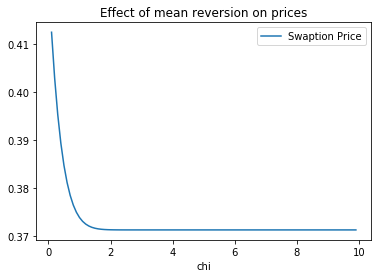

In [27]:
mean_reversion_val = np.arange(0.1,10,0.1)

swaptions = [swaption_gauss(K,maturities,lmbda,a,b,mr,lambda t: 0) for mr in mean_reversion_val]

plot2D(mean_reversion_val,swaptions,'chi','Swaption Price','Effect of mean reversion on prices')

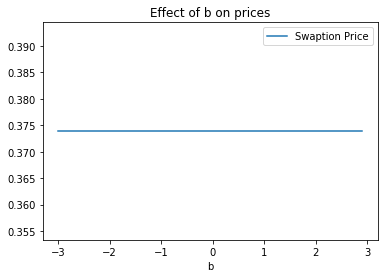

In [33]:
b_val = np.arange(-3,3,0.1)

swaptions = [swaption_gauss(K,maturities,lmbda,a,bi,chi,lambda t: 0) for bi in b_val]

plot2D(b_val,swaptions,'b','Swaption Price','Effect of b on prices')

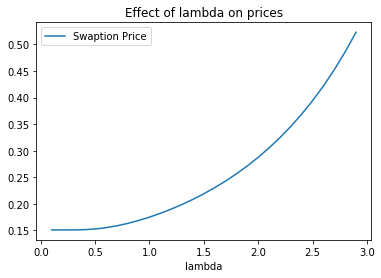

In [16]:
lmbdas = np.arange(0.1,3,0.1)

swaptions1 = [swaption_gauss(K,maturities,l,a,b,chi,lambda t: 0) for l in lmbdas]

plot2D(lmbdas,swaptions1,'lambda','Swaption Price','Effect of lambda on prices')

### First order approximation of $\mathbb{E}_{\mathbb{Q}^A} \big[x(t) \big]$

If $(t,s) \rightarrow X(t,s)$ is the solution to $\color{red} {(1)}$: $S(t,X(t,s),\bar{y}(t)) = s$ and if one notes $x_0(t) = X(t,S(0))$

Recalling that $$S(t,x,y) = \frac{P(t,T_0,x,y)-P(t,T_N,x,y)}{\sum_{n=0}^{N-1} \tau_n P(t,T_{n+1},x,y)}$$ the swap rate is smooth, increasing and 2 times differentiable in x.  

Assuming that $S$ is a square integrable martingale under annuity measure, then by martingale representation theorem and Itô's formula, one has $\mathrm{d}S(t) = \frac{\partial S}{\partial x}(s,x(t),y(t)) \ \sigma_r(s,x(t)) \ \mathrm{d}W_t^A$ 

So for $(t,s)$ such that $\frac{\partial S}{\partial x}(t,X(t,s),\bar{y}(t)) \ne 0$, $X$ is also 2-times differentiable.

Then by Taylor's formula $$x(t) = X(t,S(t)) = x_0(t) + \frac{\partial X}{\partial s}(t,S(0)) \ \times (S(t) - S(0)) + \mathcal{O} (S(t)-S(0))^2$$ and by taking the expectation under annuity measure, as the swap rate is a $\mathbb{Q}^A$ martingale one has $$\boxed{\mathbb{E}_{\mathbb{Q}^A} \big[x(t)\big] - x_0(t) = \mathcal{O} (\mathbb{E}_{\mathbb{Q}^A}(S(t)-S(0))^2 )}$$

### Second order approximation

The second order approximation is given by: $$x(t)- x_0(t) = \frac{\partial X}{\partial s}(t,S(0)) \ \times (S(t) - S(0)) + \frac{1}{2}\frac{\partial^2 X}{\partial s^2}(t,S(0)) \times (S(t)-S(0))^2 + \mathcal{O} ((S(t)-S(0))^3 )$$ 

By taking expectation again, it yields $$\boxed{\mathbb{E}_{\mathbb{Q}^A} \big[x(t)\big] = x_0(t) + \frac{1}{2}\frac{\partial^2 X}{\partial s^2}(t,S(0)) \times Var^A [S(t)] + \mathcal{O} (\mathbb{E}_{\mathbb{Q}^A}(S(t)-S(0))^3 )}$$ **(1/2 vanishes?)**

One needs to express the second derivative of X by differentiating two times $\color{red}{(1)}$ in s $$\frac{\partial^2 X}{\partial s^2}(t,s) = -\frac{\frac{\partial^2 S}{\partial x^2}(t,X(t,s),\bar{y}(t))}{\Big( \frac{\partial S}{\partial x}(t,X(t,s),\bar{y}(t)) \Big)^3}$$

**Remark: The difficulty lies in the expression of the variance because the volatility of the swap rate is stochastic. One has therefore $$Var^A[S(t)] = \mathbb{E}_{\mathbb{Q}^A} \Big[ \int_0^t \frac{\partial S}{\partial x}(s,x(s),\bar{y}(s))^2 \sigma_r(s,x(s))^2 \ \mathrm{d}s \Big]$$ which would be approximate by a Monte Carlo algorithm for instance.
But one possibility is to assume the swap rate gaussian with a deterministic volatility $\frac{\partial S}{\partial x}(s,0,0) \sigma_r(s,0)$ such that $Var^A[S(t)] \approx \int_0^t \frac{\partial S}{\partial x}(s,0,0)^2 \sigma_r(s,0)^2 \ \mathrm{d}s$** 

### b.Pricing with first order approximation for x

In [51]:
#First order approximation x0(t)

def x0(t,maturities,lmbda,a,chi):
    A0 = A(0,0,0,maturities,chi)
    S0 = S(0,0,0,maturities,chi)
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    y = y0(t,lmbda,a,chi)
    Swap_rate = lambda x: S(t,x,y,maturities,chi) - S0
    dS = lambda x: q(t,x,y,maturities,chi)
    return opt.newton(Swap_rate,0,dS)

In [52]:
#test
t = 0.5
y = y0(t,lmbda,a,chi)
S0 = (np.exp(-r*maturities[0])-np.exp(-r*maturities[-1]))/A0
x = x0(t,maturities, lmbda,a,chi)
print("x0= ",x,"S0= ",S0,"S(t,x0,y_bar)= ",S(t,x,y,maturities,chi))

x0=  -0.21812673662705018 S0=  1.718281828459045 S(t,x0,y_bar)=  1.718281828459045


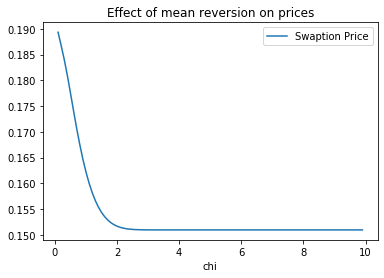

In [19]:
mean_reversion_val = np.arange(0.1,10,0.1)

swaptions = [swaption_gauss(K,maturities,lmbda,a,b,mr,lambda t: x0(t,maturities,lmbda,a,mr)) for mr in mean_reversion_val]

plot2D(mean_reversion_val,swaptions,'chi','Swaption Price','Effect of mean reversion on prices')

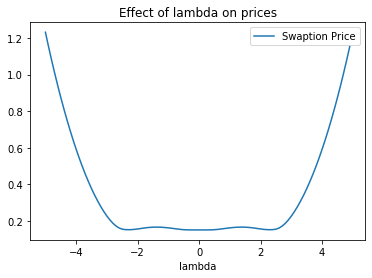

In [69]:
lmbdas = np.arange(-5,5,0.1)

swaptions1 = [swaption_gauss(K,maturities,l,a,b,chi,lambda t: x0(t,maturities,l,a,chi)) for l in lmbdas]

plot2D(lmbdas,swaptions1,'lambda','Swaption Price','Effect of lambda on prices')

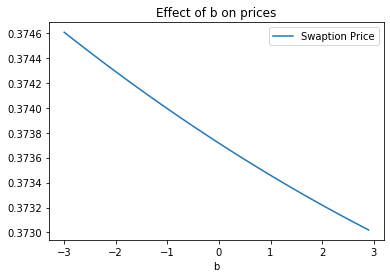

In [31]:
b_vals = np.arange(-3,3,0.1)

swaptions = [swaption_gauss(K,maturities,lmbda,a,bi,chi,lambda t: x0(t,maturities,lmbda,a,chi)) for bi in b_vals]

plot2D(b_vals,swaptions,'b','Swaption Price','Effect of b on prices')

**Remark:** The negative slope of the swaption price with respect to b is explained by the fact that $\frac{\partial V_0}{\partial \sqrt{v}} \ge 0$ and that the integrated function in $v$ becomes flat when b increases. 

Detail: $$\frac{\partial V_0}{\partial \sqrt{v}} = -A(0) \frac{(S(0)-K)^2}{v} \phi(d) + A(0) \phi(d) - A(0) \phi '(d) \frac{(S(0)-K)}{\sqrt{v}} = A(0) \phi(d) \big[ 1 - d^2 + d^2\big] = A(0) \phi(d) \ge 0$$

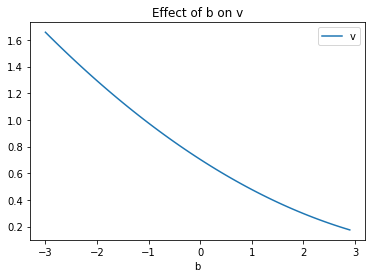

In [49]:
v = np.zeros(b_vals.size)
for i in range(b_vals.size):
    v[i] = integrate.quad(lambda t: q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 *(a + b_vals[i]*x0(t,maturities,lmbda,a,chi))**2 ,0,maturities[0])[0]
plot2D(b_vals,v,'b',"v","Effect of b on v")

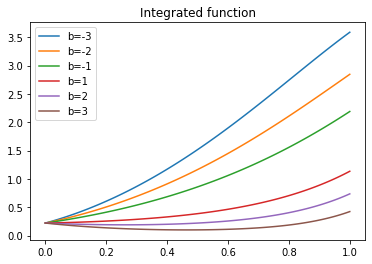

In [54]:
t_val = np.linspace(0,T0,100)
x = [q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 * (a+1*x0(t,maturities,lmbda,a,chi))**2 for t in t_val]
y = [q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 * (a+2*x0(t,maturities,lmbda,a,chi))**2 for t in t_val]
z = [q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 * (a-3*x0(t,maturities,lmbda,a,chi))**2 for t in t_val]
u = [q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 * (a-2*x0(t,maturities,lmbda,a,chi))**2 for t in t_val]
v = [q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 * (a-1*x0(t,maturities,lmbda,a,chi))**2 for t in t_val]
w = [q(t,x0(t,maturities,lmbda,a,chi),y0(t,lmbda,a,chi),maturities,chi)**2 * (a+3*x0(t,maturities,lmbda,a,chi))**2 for t in t_val]
plt.plot(t_val,z,label="b=-3")
plt.plot(t_val,u,label="b=-2")
plt.plot(t_val,v,label="b=-1")
plt.plot(t_val,x,label="b=1")
plt.plot(t_val,y,label="b=2")
plt.plot(t_val,w,label="b=3")
plt.title("Integrated function")
plt.legend()

### c.Pricing with second order approximation for x

One precises the calculus of the second derivative term in $\bar{x}(t)$.
By differentiating 2 times the expression of swap rate in x, it yields $$\begin{array}{ll}
\frac{\partial S}{\partial x}(t,x,y) = \frac{-1}{A(t,x,y)} \Big(G(t,T_0) P(t,T_0,x,y) - G(t,T_N) P(t,T_N,x,y) \Big) + \frac{S(t,x,y)}{A(t,x,y)} \sum_{n=0}^{N-1} \tau_n G(t,T_{n+1}) P(t,T_{n+1},x,y) \quad \\ \text{and} \
\frac{\partial^2 S}{\partial x^2}(t,x,y) = \frac{1}{A(t,x,y)} \Big[ G(t,T_0)^2 P(t,T_0,x,y) - G(t,T_N)^2 P(t,T_N,x,y) - S(t,x,y) \frac{\partial^2 A}{\partial x^2} \Big] + \frac{\partial A}{\partial x} \Big[ \frac{\frac{\partial S}{\partial x}}{A(t,x,y)} - \frac{G(t,T_0) P(t,T_0,x,y) - G(t,T_N) P(t,T_N,x,y)}{A(t,x,y)^2} \Big] + \Big( \frac{\partial A}{\partial x} \Big)^2 \frac{S(t,x,y)}{A(t,x,y)^2} \\
= \frac{1}{A(t,x,y)} \Big[ G(t,T_0)^2 P(t,T_0,x,y) - G(t,T_N)^2 P(t,T_N,x,y) - S(t,x,y) A''(t,x,y) \Big] +\frac{2 A'(t,x,y)}{A(t,x,y)^2} \Big( A'(t,x,y) S(t,x,y) - \big(G(t,T_0) P(t,T_0,x,y) - G(t,T_N) P(t,T_N,x,y)\big) \Big)
\end{array}$$

Where $A' \& A''$ are derivatives with respect to $x$

In [53]:
#second order approximation 

def x_bar(t,maturities,lmbda,a,chi):
    y = y0(t,lmbda,a,chi)
    x = x0(t,maturities,lmbda,a,chi)
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    At = A(t,x,y,maturities,chi)
    Aprime = A(t,x,y,maturities,chi,1)
    Apprime = A(t,x,y,maturities,chi,2)
    S_rate = S(t,x,y,maturities,chi)
    #second derivative d2S/dx2
    dS2 = (g0**2 * PT0 - gN**2 * PTN - S_rate * Apprime)/At + 2*Aprime * (Aprime*S_rate - g0*PT0 + gN*PTN)/(At**2)
    #second derivative d2X/ds2
    dX2 = -1*dS2/(q(t,x,y,maturities,chi)**3)
    Var = lmbda**2 * a**2 *integrate.quad(lambda s:  q(s,0,0,maturities,chi)**2,0,t)[0]
    return x + 0.5 * dX2 * Var

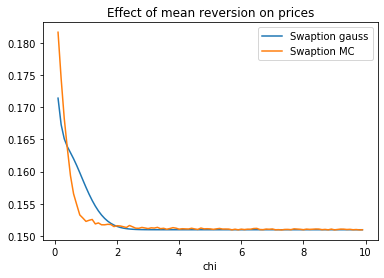

In [56]:
mean_reversion_val = np.arange(0.1,10,0.1)

swaptions = [swaption_gauss(K,maturities,lmbda,a,b,mr,lambda t: x_bar(t,maturities,lmbda,a,mr)) for mr in mean_reversion_val]
swaptions2 = [swaption(M,N,T0,K,lmbda,a,b,mr,bonds,maturities) for mr in mean_reversion_val]
plot2D(mean_reversion_val,swaptions,'chi','Swaption gauss','Effect of mean reversion on prices',swaptions2,"Swaption MC")

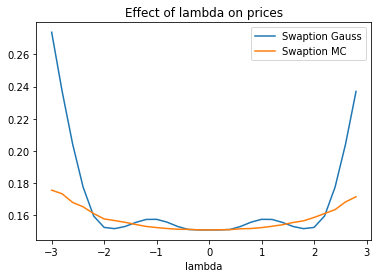

In [58]:
lmbdas = np.arange(-3,3,0.2)

swaptions1 = [swaption_gauss(K,maturities,l,a,b,chi,lambda t: x_bar(t,maturities,l,a,chi)) for l in lmbdas]
swaptions2 = [swaption(M,N,T0,K,l,a,b,chi,bonds,maturities) for l in lmbdas]
plot2D(lmbdas,swaptions1,'lambda','Swaption Gauss','Effect of lambda on prices',swaptions2,"Swaption MC")

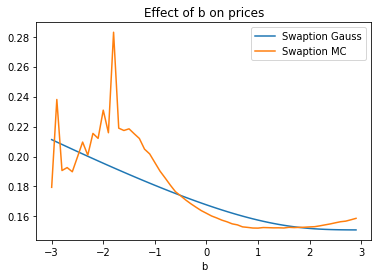

In [59]:
b_vals = np.arange(-3,3,0.1)

swaptions1 = [swaption_gauss(K,maturities,lmbda,a,bi,chi,lambda t: x_bar(t,maturities,lmbda,a,chi)) for bi in b_vals]
swaptions2 = [swaption(M,N,T0,K,lmbda,a,bi,chi,bonds,maturities) for bi in b_vals]
plot2D(b_vals,swaptions1,'b','Swaption Gauss','Effect of b on prices',swaptions2,"Swaption MC")

## $\chi$ piecewise constant 
(see "One factor Gaussian short rate model implementation", Caspers)

$$\chi(t) = \sum_{i=0}^{N-1} \chi_i \ \mathbb{1}_{t \in [t_i,t_{i+1}[}$$

Then closed formulas for $G$ and $y$ will change.
One notes $U(t) = \inf { \{i \in [|0,N|], \ t_i \ge t\}}$ and $l(t) = \sup { \{i \in [|0,N|], \ t_i \le t\}}$

**changes for G:** 
$$e^{-\int_{t}^{u} \chi(s) \ \mathrm{d}s} = \prod_{i=l(t)}^{U(u)-1} e^{-\chi_{i}\left(t_{i+1} \wedge u-t_i \vee t\right)}$$

$$G\left(t, T \right)=\sum_{i=l(t)}^{U\left(T\right)-1} \int_{t_i \vee t}^{T \wedge t_{i+1}}\left(\prod_{j=l(t)}^{i-1} e^{-\kappa_{j}\left(t_{j+1}-t_j \vee t\right)}\right) e^{-\kappa_{i}\left(u-t_i \vee t\right)} d u \\
= \sum_{i=l(t)}^{U\left(T\right)-1} \Big( \frac{1-e^{\chi_i(T \wedge t_{i+1} - t \vee t_i)}}{\chi_i} \Big) \prod_{j=l(t)}^{i-1} e^{-\kappa_{j}\left(t_{j+1}-t_j \vee t\right)}
$$

**changes for y:** 